## Titanic - Machine Learning from Diaster
This is the legendary Titanic ML competition – the best, first challenge for you to dive into ML competitions and familiarize yourself with how the Kaggle platform works.

The competition is simple: use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.

In [14]:
#All necessary imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier

%matplotlib inline

In [2]:
#load the train data
train_data = pd.read_csv('train.csv')

### Exploratory Data Analysis

In [3]:
#Exploratory Data Analysis
#First 10 rows
train_data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


Survived = {0: No, 1:Yes}

Pclass = {1: first class, 2: second class, 3: third class}

SibSp = Siblings or Spouse

Parch = Parents or children

Embarked = {C:Cherbourg, Q:Queenstown, S:Southampton}

##### PassengerId, Name, Ticket will be dropped as they are not contributing factors to survivor. Embarked will be kept out of curiosity even though it shouldn't affect survivability

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Age, Cabin and Embarked has null entries. To decide if they are to be dropped by looking at their percentage missing values.

In [4]:
age_missing_pct = (train_data['Age'].isnull().sum()/train_data.shape[0])*100
cabin_missing_pct = (train_data['Cabin'].isnull().sum()/train_data.shape[0])*100
embarked_missing_pct = (train_data['Embarked'].isnull().sum()/train_data.shape[0])*100

print('Missing values percentage in "Age" columns: {:0.2f}'.format(age_missing_pct))
print('Missing values percentage in "Cabin" columns: {:0.2f}'.format(cabin_missing_pct))
print('Missing values percentage in "Embarked" columns: {:0.2f}'.format(embarked_missing_pct))

Missing values percentage in "Age" columns: 19.87
Missing values percentage in "Cabin" columns: 77.10
Missing values percentage in "Embarked" columns: 0.22


"Cabin" column will be dropped as 77.1% of values are missing. "Age" and "Embarked" will be kept and re-engineered

#### Drop columns that have too many missing values and not contributing to survivability

In [5]:
#Drop 'Cabin', 'PassengerId', 'Name', 'Ticket' columns
train_data_drop = train_data[:]
train_data_drop = train_data_drop.drop(['Cabin', 'PassengerId', 'Name', 'Ticket'],axis=1)
train_data_drop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


In [6]:
train_data_drop.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
5,0,3,male,NaN,0,0,8.4583,Q
6,0,1,male,54.0,0,0,51.8625,S
7,0,3,male,2.0,3,1,21.0750,S
8,1,3,female,27.0,0,2,11.1333,S
9,1,2,female,14.0,1,0,30.0708,C


#### Fill missing data for Age and Embarked

In [7]:
#Looking at the "Age" column
train_data_drop['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

array([[<AxesSubplot:title={'center':'Age'}>]], dtype=object)

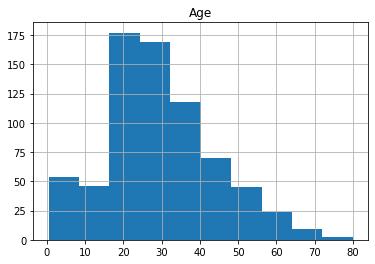

In [9]:
train_data_drop.hist(column='Age')

In [8]:
#To bfill the "Age" and "Embarked" column
train_data_bfill = train_data_drop[:]
cols = ['Age', 'Embarked']
train_data_bfill.loc[:, cols]= train_data_bfill.loc[:,cols].bfill()
train_data_bfill.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  891 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


#### Re-encode categorical data

In [9]:
#To encode categorical columns "Sex" and "Embarked"
#Sex => male: 1, female: 2 / Embarked => C:1, Q:2, S:3
train_data_encode = train_data_bfill[:]
train_data_encode.loc[:,'Sex'] = train_data_encode.loc[:,'Sex'].replace(['male', 'female'], [1,2])
train_data_encode.loc[:,'Embarked'] = train_data_encode.loc[:,'Embarked'].replace(['C', 'Q', 'S'], [1,2,3])
train_data_encode.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,3
1,1,1,2,38.0,1,0,71.2833,1
2,1,3,2,26.0,0,0,7.9250,3
3,1,1,2,35.0,1,0,53.1000,3
4,0,3,1,35.0,0,0,8.0500,3
5,0,3,1,54.0,0,0,8.4583,2
6,0,1,1,54.0,0,0,51.8625,3
7,0,3,1,2.0,3,1,21.0750,3
8,1,3,2,27.0,0,2,11.1333,3
9,1,2,2,14.0,1,0,30.0708,1


### Feature Importance Selection
To look at Feature Importance to further drop columns that are not needed. 

C:\Users\kianm\AppData\Local\Temp\ipykernel_6756\2159779736.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X, y)


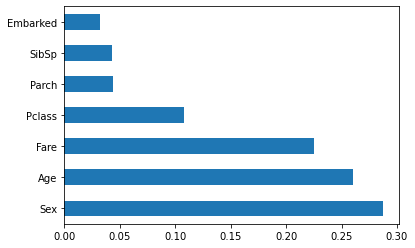

In [13]:
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier()
X = train_data_encode.iloc[:,1:8]
y = train_data_encode.iloc[:,0:1]

model.fit(X, y)

feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()


C:\Users\kianm\AppData\Local\Temp\ipykernel_6756\2697153531.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X, y)


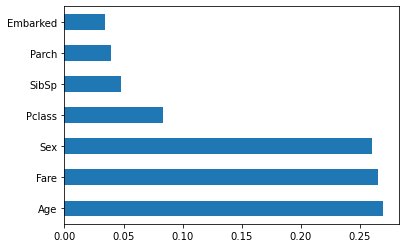

In [14]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
X = train_data_encode.iloc[:,1:8]
y = train_data_encode.iloc[:,0:1]

model.fit(X, y)

feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()


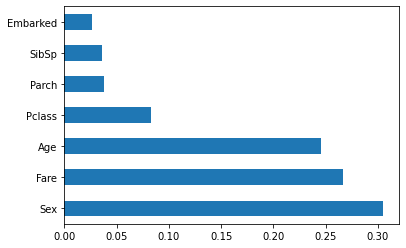

In [15]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
X = train_data_encode.iloc[:,1:8]
y = train_data_encode.iloc[:,0:1]

model.fit(X, y)

feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

##### Sex, Age, Fare, Pclass all score high in feature importance for the 3 tree classifiers and will be kept. Pclass is related to Fare, Pclass may be dropped

````````````d

#### Drop Embarked, SibSp and Parch

In [10]:
train_data_feature_drop = train_data_encode[:]
train_data_feature_drop = train_data_feature_drop.drop(['Embarked', 'SibSp', 'Parch'], axis=1)
train_data_feature_drop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    int64  
 3   Age       891 non-null    float64
 4   Fare      891 non-null    float64
dtypes: float64(2), int64(3)
memory usage: 34.9 KB


##### Plotting graphs to see "spread of data" to evaluate if it's linear or classification

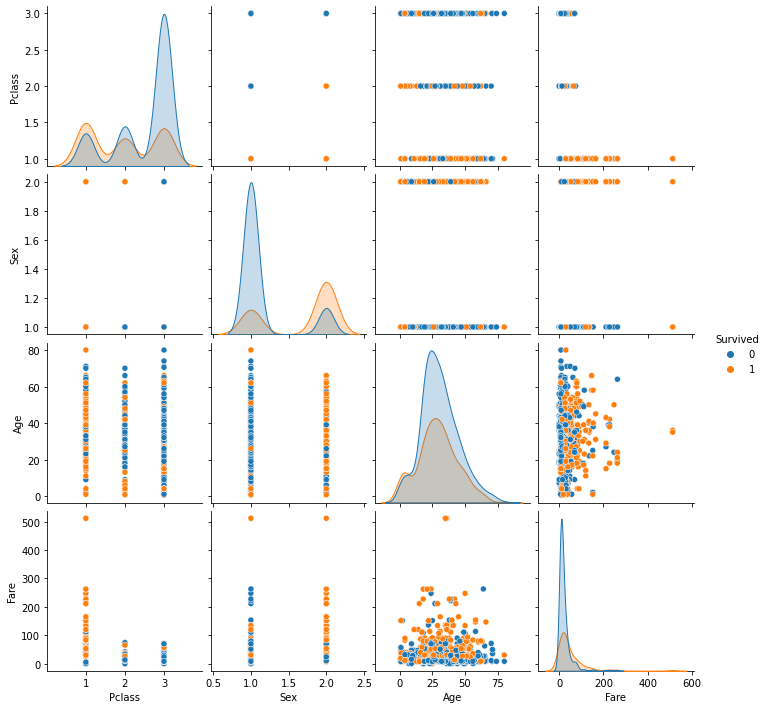

In [28]:
#To see the spread of data points to evaluate if it's linear or classification
import seaborn as sns

sns.pairplot(train_data_feature_drop, hue='Survived')

#### Which model to use?


Logistic Regression, Random Forest, Decision Trees, ExtraTreesClassifier

In [11]:
from sklearn.model_selection import train_test_split

X = train_data_feature_drop.iloc[:,1:8]
y = train_data_feature_drop.iloc[:,0:1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import GridSearchCV

clf = DecisionTreeClassifier(random_state=42)

# parameters list you wish to tune.
parameters = {'max_depth': [2, 4, 6, 8,10,12,14,16], 'min_samples_leaf':[2,4,6,8,10,12,14,16], 'min_samples_split': [2,4,6,8,10,12,14,16]}

# Call the function
calculate_F1_Score(parameters)

The training F1 Score is 0.8247011952191234
The testing F1 Score is 0.7826086956521738
DecisionTreeClassifier(max_depth=10, min_samples_leaf=6, random_state=42)


In [21]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=42)

y_train= y_train.values.ravel()
# Create the parameters list you wish to tune.
parameters = {'max_depth': [2, 4, 6, 8,10,12,14,16], 'min_samples_leaf':[2,4,6,8,10,12,14,16], 'min_samples_split': [2,4,6,8,10,12,14,16]}

calculate_F1_Score(parameters)

The training F1 Score is 0.7670103092783506
The testing F1 Score is 0.7391304347826088
RandomForestClassifier(max_depth=4, min_samples_leaf=2, min_samples_split=6,
                       random_state=42)


In [22]:
from sklearn.ensemble import ExtraTreesClassifier

clf = ExtraTreesClassifier(random_state=42)
#y_train= y_train.values.ravel()
# Create the parameters list you wish to tune.
parameters = {'max_depth': [2, 4, 6, 8,10,12,14,16], 'min_samples_leaf':[2,4,6,8,10,12,14,16], 'min_samples_split': [2,4,6,8,10,12,14,16]}

calculate_F1_Score(parameters)

The training F1 Score is 0.8132780082987552
The testing F1 Score is 0.75
ExtraTreesClassifier(max_depth=16, min_samples_leaf=2, min_samples_split=10,
                     random_state=42)


#### Trying AdaBoost

In [17]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import make_scorer, f1_score

ada_boost = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth=4), n_estimators = 20, learning_rate=0.2)
ada_model = ada_boost.fit(X_train, y_train.values.ravel())

ada_predict_test = ada_model.predict(X_test)

ada_predict_train = ada_model.predict(X_train)


# Calculate the f1_score of the new model
print('The testing F1 Score is', f1_score(ada_predict_test, y_test))
print('The training F1 Score is', f1_score(ada_predict_train, y_train))


The testing F1 Score is 0.7972027972027972
The training F1 Score is 0.9296874999999999


##### AdaBoost chosen as it has the highest training score testing score:

##### AdaBoost

The training F1 Score is 0.9296874999999999

The testing F1 Score is 0.7972027972027972

##### ExtraTreesClassifier

The training F1 Score is 0.8132780082987552

The testing F1 Score is 0.75

##### RandomForestClassifier

The training F1 Score is 0.7670103092783506

The testing F1 Score is 0.7391304347826088

##### DecisionTreeClassifier

The training F1 Score is 0.8247011952191234

The testing F1 Score is 0.7826086956521738

In [21]:
#Choosing the best parameters for Adaboost with RepeatedStratifiedKFold and GridSearchCV

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier

# define the model with default hyperparameters
model = AdaBoostClassifier()

# define the grid of values to search
grid = dict()
grid['n_estimators'] = [10, 50, 100, 500]
grid['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]

# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# define the grid search procedure
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy')

# execute the grid search
grid_result = grid_search.fit(X_train, y_train)

# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

c:\Users\kianm\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best: 0.806149 using {'learning_rate': 1.0, 'n_estimators': 100}
0.787898 (0.045396) with: {'learning_rate': 0.0001, 'n_estimators': 10}
0.787898 (0.045396) with: {'learning_rate': 0.0001, 'n_estimators': 50}
0.787898 (0.045396) with: {'learning_rate': 0.0001, 'n_estimators': 100}
0.787898 (0.045396) with: {'learning_rate': 0.0001, 'n_estimators': 500}
0.787898 (0.045396) with: {'learning_rate': 0.001, 'n_estimators': 10}
0.787898 (0.045396) with: {'learning_rate': 0.001, 'n_estimators': 50}
0.787898 (0.045396) with: {'learning_rate': 0.001, 'n_estimators': 100}
0.787898 (0.045396) with: {'learning_rate': 0.001, 'n_estimators': 500}
0.787898 (0.045396) with: {'learning_rate': 0.01, 'n_estimators': 10}
0.787898 (0.045396) with: {'learning_rate': 0.01, 'n_estimators': 50}
0.787898 (0.045396) with: {'learning_rate': 0.01, 'n_estimators': 100}
0.790245 (0.044272) with: {'learning_rate': 0.01, 'n_estimators': 500}
0.787898 (0.045396) with: {'learning_rate': 0.1, 'n_estimators': 10}
0.789776

In [15]:
# To use AdaBoost with learning rate: 1.0, n_estimators:100

model = AdaBoostClassifier(learning_rate=1.0, n_estimators=100)

model_fit = model.fit(X_train, y_train.values.ravel())

test_pred = model_fit.predict(X_test)

train_pred = model_fit.predict(X_train)

print('The train F1 Score is', f1_score( train_pred, y_train))
print('The testing F1 Score is', f1_score( test_pred, y_test))


The train F1 Score is 0.7844660194174756
The testing F1 Score is 0.7552447552447553


In [23]:
test_data = pd.read_csv('test.csv')

#Drop 'Cabin', 'PassengerId', 'Name', 'Ticket' columns
test_data_drop = test_data
test_data_drop = test_data_drop.drop(['Cabin','PassengerId', 'Name', 'Ticket'],axis=1)

#To ffill the "Age" and "Embarked" column
test_data_ffill = test_data_drop
cols = ['Age', 'Embarked', 'Fare']
test_data_ffill.loc[:, cols]= test_data_ffill.loc[:,cols].ffill()

#To encode categorical columns "Sex" and "Embarked"
#Sex => male: 1, female: 2 / Embarked => C:1, Q:2, S:3
test_data_encode = test_data_ffill
test_data_encode.loc[:,'Sex'] = test_data_encode.loc[:,'Sex'].replace(['male', 'female'], [1,2])
test_data_encode.loc[:, 'Embarked'] = test_data_encode.loc[:, 'Embarked'].replace(['C', 'Q', 'S'], [1, 2, 3])

#Drop Embarked, SibSp and Parch
test_data_feature_drop = test_data_encode
test_data_feature_drop = test_data_feature_drop.drop(['Embarked', 'SibSp', 'Parch'], axis=1)

test_data_feature_drop.head()

,Pclass,Sex,Age,Fare
0,3,1,34.5,7.8292
1,3,2,47.0,7.0000
2,2,1,62.0,9.6875
3,3,1,27.0,8.6625
4,3,2,22.0,12.2875


In [24]:
#Predict survival of test data
model_test_data_pred = model_fit.predict(test_data_feature_drop)
model_test_data_pred

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [27]:
#Combined prediction with 'PassengerID' to form dataframe and csv for submission
submission_df = pd.DataFrame({'PassengerID':test_data['PassengerId'], 'Survived':model_test_data_pred})
submission_df.to_csv('submission_km.csv',index=False)